In [1]:
#rebuild tensorflow with comiler flags
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from tensorflow.python.keras.metrics import Metric

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings

# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
#Import CO2 emissions data - OWID
data = pd.read_csv('../Data/carbon-emissions/owid-co2-data.csv')

#Observe data shape and head
print(data.shape)

(25204, 58)


In [3]:
data.head()

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,0.002,NaN,0.0,0.015,0.0,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,NaN,475.0,0.070,NaN,0.011,NaN,0.0,0.099,0.0,0.009,NaN,NaN,0.021,NaN,NaN,NaN,0.063,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.036,NaN,NaN,0.063,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,NaN,8.7,0.007,NaN,0.012,NaN,0.0,0.191,0.0,0.010,NaN,NaN,0.026,NaN,NaN,NaN,0.066,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.061,NaN,NaN,0.129,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,NaN,0.0,0.000,NaN,0.012,NaN,0.0,0.282,0.0,0.009,NaN,NaN,0.032,NaN,NaN,NaN,0.060,NaN,NaN,0.004,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.093,NaN,NaN,0.189,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,NaN,16.0,0.015,NaN,0.013,NaN,0.0,0.388,0.0,0.010,NaN,NaN,0.038,NaN,NaN,NaN,0.068,NaN,NaN,0.005,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.131,NaN,NaN,0.257,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [4]:
data.tail()

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
25199,ZWE,Zimbabwe,2016,10.738,12.153,-12.17,-1.488,1.415,0.765,0.866,0.03,736.467,0.05,0.512,0.580,0.226,6.959,0.639,NaN,NaN,3.139,NaN,0.046,0.496,NaN,NaN,0.224,NaN,13.18,0.04,0.05,NaN,NaN,0.03,NaN,18.188,585.104,NaN,NaN,133.175,NaN,0.05,0.08,NaN,NaN,0.02,NaN,65.98,4.703,11.92,0.85,6.55,0.467,14030338.0,2.096179e+10,47.5,3385.574,1.889
25200,ZWE,Zimbabwe,2017,9.582,11.248,-10.77,-1.156,1.666,0.673,0.790,0.03,746.049,0.05,0.437,0.512,NaN,5.665,0.678,NaN,NaN,3.239,NaN,0.048,0.398,NaN,NaN,0.228,NaN,17.39,0.05,0.04,NaN,NaN,0.03,NaN,18.866,590.768,NaN,NaN,136.414,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14236599.0,2.194784e+10,NaN,NaN,NaN
25201,ZWE,Zimbabwe,2018,11.854,13.163,23.72,2.273,1.308,0.821,0.912,0.03,757.903,0.05,0.522,0.580,NaN,7.101,0.697,NaN,NaN,4.056,NaN,0.048,0.492,NaN,NaN,0.281,NaN,11.04,0.04,0.05,NaN,NaN,0.03,NaN,19.564,597.869,NaN,NaN,140.470,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14438812.0,2.271535e+10,NaN,NaN,NaN
25202,ZWE,Zimbabwe,2019,10.949,12.422,-7.64,-0.905,1.473,0.748,0.848,0.03,768.852,0.05,NaN,NaN,NaN,6.020,0.697,NaN,NaN,4.232,NaN,0.048,0.411,NaN,NaN,0.289,NaN,13.45,0.04,0.04,NaN,NaN,0.03,NaN,20.261,603.889,NaN,NaN,144.702,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14645473.0,NaN,NaN,NaN,NaN
25203,ZWE,Zimbabwe,2020,10.531,NaN,-3.82,-0.418,NaN,0.709,NaN,0.03,779.383,0.05,NaN,NaN,NaN,6.257,0.697,NaN,NaN,3.576,NaN,0.047,0.421,NaN,NaN,0.241,NaN,NaN,0.04,0.04,NaN,NaN,0.03,NaN,20.959,610.146,NaN,NaN,148.279,NaN,0.05,0.08,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,25204.000000,23949.000000,3976.000000,24931.000000,23585.000000,3976.000000,23307.000000,3976.000000,23949.000000,2.394900e+04,23949.000000,15389.000000,3761.000000,9141.000000,17188.000000,12248.000000,4382.000000,8845.000000,20539.000000,1999.000000,12218.000000,16860.000000,4381.000000,8835.000000,20181.000000,1999.000000,3976.000000,12248.000000,17188.00000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,5208.000000,5155.000000,5211.000000,5157.000000,5211.000000,5157.000000,2.287800e+04,1.353800e+04,8690.000000,8681.000000,6803.000000
mean,1953.225797,267.861942,916.755170,21.098600,5.146889,-2.415624,4.170811,6.567721,4.983979,1.035710e+04,5.126531,0.421795,0.370038,0.238931,175.358171,12.888607,15.000326,108.750774,106.254381,15.753891,0.113037,1.551520,0.875319,1.413336,2.635498,0.080168,22.961190,4.419452,6.98983,5.861506,5.405564,2.993497,14.295183,307.761167,8791.767180,425.698588,2587.096729,3296.584230,293.588436,4.462228,7.211834,5.621670,5.242400,3.001620,13.403622,441.481429,8.099506,82.253370,2.046923,29.308135,0.606690,7.072322e+07,2.877088e+11,1569.083895,25568.487454,1.850291
std,53.791369,1521.680894,3373.348275,702.565991,55.259760,182.444942,14.912201,6.927957,17.704994,6.120603e+04,18.480079,0.483864,0.265374,0.233550,786.106838,77.258563,40.471977,441.064563,602.683622,39.385589,0.148907,2.552112,5.477923,3.654290,15.129275,0.055779,45.055039,15.950613,20.76197,14.874259,18.408881,12.018682,28.570911,1706.159528,39131.720328,1320.911296,12347.690600,21645.263301,777.706862,15.685264,21.636504,15.021334,18.926934,12.134102,27.019447,3089.039496,9.387477,566.702756,3.534126,199.291118,0.844671,3.795858e+08,2.180094e+12,9066.102799,33319.956208,1.575161
min,1750.000000,0.000000,0.197000,-99.640000,-1895.244000,-1657.998000,0.000000,0.055000,0.000000,0.000000e+00,0.000000,0.000000,0.006000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-96.760000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-85.620000,-50.487000,0.000000,0.000000,0.000000,0.000000,1.490000e+03,5.543200e+07,0.000000,0.000000,0.050000
25%,1925.000000,0.528000,10.319750,-0.450000,-0.011000,-0.892500,0.253000,1.240250,0.010000,6.992000e+00,0.000000,0.140000,0.216000,0.178000,0.322000,0.129000,0.253250,0.385000,0.311000,0.747500,0.020000,0.054000,0.021000,0.031000,0.121000,0.036000,-1.757500,0.050000,0.01000,0.090000,0.030000,0.010000,0.300000,1.613000,5.516250,4.071250,3.239000,3.921000,7.709000,0.040000,0.000000,0.060000,0.010000,0.010000,0.190000,8.162500,2.514000,2.150000,0.715000,0.535000,0.228000,1.291899e+06,9.828867e+09,6.997000,3270.369000,0.856000
50%,1967.00

## Data Cleaning and Preprocessing  

In [6]:
#check for null values
data.isnull().sum()

iso_code                                3256
country                                    0
year                                       0
co2                                     1255
consumption_co2                        21228
co2_growth_prct                          273
co2_growth_abs                          1619
trade_co2                              21228
co2_per_capita                          1897
consumption_co2_per_capita             21228
share_global_co2                        1255
cumulative_co2                          1255
share_global_cumulative_co2             1255
co2_per_gdp                             9815
consumption_co2_per_gdp                21443
co2_per_unit_energy                    16063
coal_co2                                8016
cement_co2                             12956
flaring_co2                            20822
gas_co2                                16359
oil_co2                                 4665
other_industry_co2                     23205
cement_co2

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             21948 non-null  object 
 1   country                              25204 non-null  object 
 2   year                                 25204 non-null  int64  
 3   co2                                  23949 non-null  float64
 4   consumption_co2                      3976 non-null   float64
 5   co2_growth_prct                      24931 non-null  float64
 6   co2_growth_abs                       23585 non-null  float64
 7   trade_co2                            3976 non-null   float64
 8   co2_per_capita                       23307 non-null  float64
 9   consumption_co2_per_capita           3976 non-null   float64
 10  share_global_co2                     23949 non-null  float64
 11  cumulative_co2              

We focused on post-1950 data for our comparative analysis and global EDA since some countries are missing significant data before that time. Major carbon emitting countries' emission activites intensified post 1950 period, especially India. For our modelling process, however, focusing on India, the data form 1878 is continous, so we include all data for India from 1900. First, We'll be predicting and Forecasting the per capita CO2 emissions for India

In [8]:
#only include India co2 per capita data post-1900
df_India = data
df_India = df_India[df_India['year'] >= 1900]
df_India = df_India[df_India['country'] == 'India']
df_India = df_India[['year', 'co2_per_capita']]
df_India.reset_index(drop= True, inplace=True)

#observe shape of reformatted df
print(df_India.shape)

(121, 2)


In [9]:
df_India

,year,co2_per_capita
0,1900,0.041
1,1901,0.045
2,1902,0.049
3,1903,0.050
4,1904,0.056
...,...,...
116,2016,1.799
117,2017,1.818
118,2018,1.922
119,2019,1.922


In [10]:
#observe updated df
#df_India.head()
df_India.isnull().sum()


year              0
co2_per_capita    0
dtype: int64

In [11]:
# Filter the target column from dataset and convert the dataframe to numpy
target = df_India.iloc[:, 1:2].values
target.shape

(121, 1)

## Model

**Reporducibility** is extremely important as the parameter makes sure that when code is re-run, produces similar results

In [12]:
#fix random seed so that our results reproducibility
np.random.seed(42)

**Normalize Input**

As with other deep learning problems, we can help neural network learn more rapidly by normalizing the inputs between 0 and 1. We will use `MinMaxScaler` for normalizing the input

In [13]:
#normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(target) #try standard scaler

In [14]:
scaled_dataset.shape

(121, 1)

**Split intro train and test sets**

In [15]:
#split train-set
train_size = int(len(scaled_dataset)*0.90)
test_size = len(scaled_dataset) - train_size
train, test = scaled_dataset[0:train_size,:], scaled_dataset[train_size:len(scaled_dataset),:]
print(len(train), len(test))

108 13


In [16]:
train.shape

(108, 1)

In [17]:
test.shape

(13, 1)

In [18]:
# Convert the data into a Supervised-learning data

x = []
y = []
look_back = 4
for i in range(look_back, len(train)):
    x.append(train[i-look_back:i, 0])
    y.append(train[i, 0])

# Converting into numpy sequences to train the LSTM model
trainX, trainY = np.array(x), np.array(y) 

LSTM network should be fed with input data (X) with a specific array structure of form [Sample, time steps, features]

lets restructure the train and test input data to required format

In [19]:
# Reshape the training data to 3 dimensional for LSTM input.
X_train = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [20]:
X_train.shape

(104, 4, 1)

In [21]:
trainY.shape

(104,)

### Building LSTM Model

The network has a visible layer with 1 input, a hidden layer with 100 LSTM units and then gradually reducing it, and an output layer that makes a single value prediction. The relu activation function is used for the LSTM blocks.


In [22]:
#create and fit the LSTM network
modelx = Sequential()

#Add first LSTM layer with 20% dropout regularisation
modelx.add(LSTM(units = 100,
                return_sequences = True,
                activation = 'relu',
                input_shape = (X_train.shape[1], 1)))
modelx.add(Dropout(0.2))

#Add Second LSTM Layer
modelx.add(LSTM(units = 90,
                return_sequences = True,
                activation = 'relu'))
modelx.add(Dropout(0.2))

#Add Third LSTM Layer
modelx.add(LSTM(units = 90,
                activation = 'relu'))
modelx.add(Dropout(0.2))

#Add output layer
modelx.add(Dense(1))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 4, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 90)             68760     
                                                                 
 dropout_1 (Dropout)         (None, 4, 90)             0         
                                                                 
 lstm_2 (LSTM)               (None, 90)                65160     
                                                                 
 dropout_2 (Dropout)         (None, 90)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

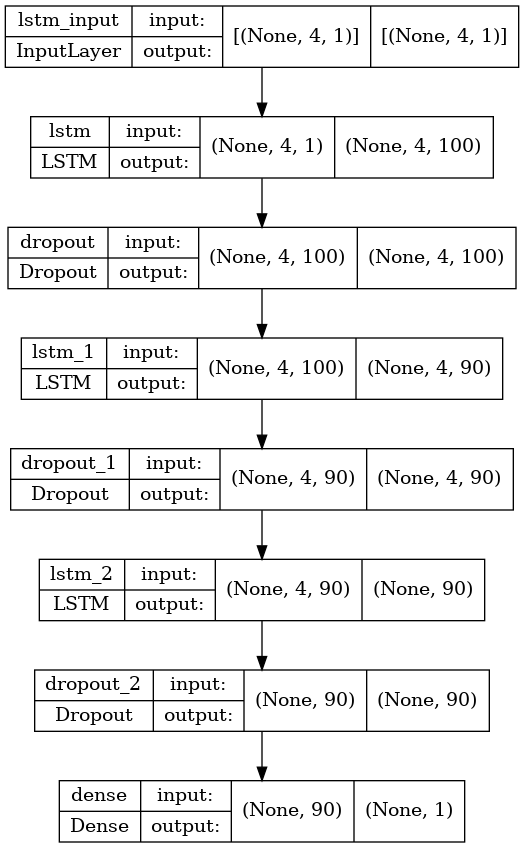

In [23]:
#print model summary
modelx.summary()

#Visualize model architecture
plot_model(modelx, show_shapes=True)

In [24]:
modelx.compile(loss='mean_squared_error', optimizer='adam')
history = modelx.fit(X_train,
                     trainY, 
                     epochs = 100, 
                     batch_size = 128, 
                     validation_split = 0.2, 
                     verbose = 1, 
                     shuffle = False)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0119 - val_loss: 0.1797
Epoch 2/100
1/1 [==============================] - 0s 69ms/step - loss: 0.0108 - val_loss: 0.1734
Epoch 3/100
1/1 [==============================] - 0s 66ms/step - loss: 0.0097 - val_loss: 0.1667
Epoch 4/100
1/1 [==============================] - 0s 65ms/step - loss: 0.0087 - val_loss: 0.1596
Epoch 5/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0076 - val_loss: 0.1521
Epoch 6/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0066 - val_loss: 0.1441
Epoch 7/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0060 - val_loss: 0.1358
Epoch 8/100
1/1 [==============================] - 0s 63ms/step - loss: 0.0052 - val_loss: 0.1271
Epoch 9/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0046 - val_loss: 0.1182
Epoch 10/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0042 - val_loss: 0.1092
Epoch 11/100
1/1 [===

1/1 [==============================] - 0s 52ms/step - loss: 1.8161e-04 - val_loss: 8.8695e-04
Epoch 83/100
1/1 [==============================] - 0s 53ms/step - loss: 1.9794e-04 - val_loss: 8.9057e-04
Epoch 84/100
1/1 [==============================] - 0s 53ms/step - loss: 1.6948e-04 - val_loss: 8.1039e-04
Epoch 85/100
1/1 [==============================] - 0s 53ms/step - loss: 1.9751e-04 - val_loss: 6.5162e-04
Epoch 86/100
1/1 [==============================] - 0s 54ms/step - loss: 1.7809e-04 - val_loss: 5.3539e-04
Epoch 87/100
1/1 [==============================] - 0s 52ms/step - loss: 1.4701e-04 - val_loss: 4.8908e-04
Epoch 88/100
1/1 [==============================] - 0s 51ms/step - loss: 1.5750e-04 - val_loss: 4.4656e-04
Epoch 89/100
1/1 [==============================] - 0s 53ms/step - loss: 1.7610e-04 - val_loss: 4.0950e-04
Epoch 90/100
1/1 [==============================] - 0s 52ms/step - loss: 2.2640e-04 - val_loss: 4.2565e-04
Epoch 91/100
1/1 [==============================] 

In [25]:
#Construct Metircs for the LSTM Model
metrics = pd.DataFrame(modelx.history.history)
metrics.head()

,loss,val_loss
0,0.011887,0.179717
1,0.010752,0.173383
2,0.009745,0.166679
3,0.008704,0.159565
4,0.007617,0.152050


Text(0, 0.5, 'Loss')

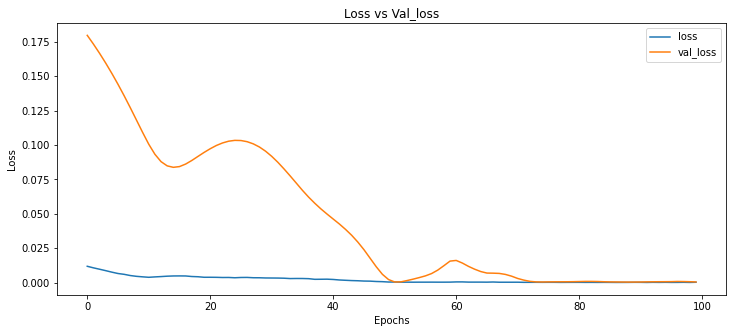

In [26]:
#Plot the loss of LSTM Model

metrics[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss vs Val_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [27]:
# Prepare the test data for validation
test_data = scaled_dataset[train_size - look_back: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[train_size : , : ]
for i in range(look_back, len(test_data)):
    X_test.append(test_data[i-look_back:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

In [28]:
# Prediction with the prepared LSTM model
predicted_CO2 = modelx.predict(X_test)

# Inverse scaling of predicted values to original scale
predicted_CO2 = scaler.inverse_transform(predicted_CO2)

predicted_CO2

array([[1.1828817],
       [1.2430075],
       [1.3216883],
       [1.4170704],
       [1.5178746],
       [1.6267331],
       [1.709737 ],
       [1.8260558],
       [1.9581997],
       [2.0465558],
       [2.155085 ],
       [2.2339637],
       [2.319215 ]], dtype=float32)

### Evaluation of LSTM Model

In [29]:
# Determine the Mean Absoulute Error
mae = mean_absolute_error(y_test,predicted_CO2)
print("Mean Absoulte Error is:", round(mae,3))

Mean Absoulte Error is: 0.141


In [30]:
# Determine the Root Mean Absoulute Error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test,predicted_CO2))
print("Root Mean Absoulute Error is:", round(rmse,3))

Root Mean Absoulute Error is: 0.206


In [31]:
#Creare a function to calculate MAPE for our models
def MAPE(pred): 
    return np.mean(np.abs((y_test - pred) / y_test)) * 100

print('Mean Absolute Percentage Error is: ', round(MAPE(predicted_CO2),3))


Mean Absolute Percentage Error is:  8.026


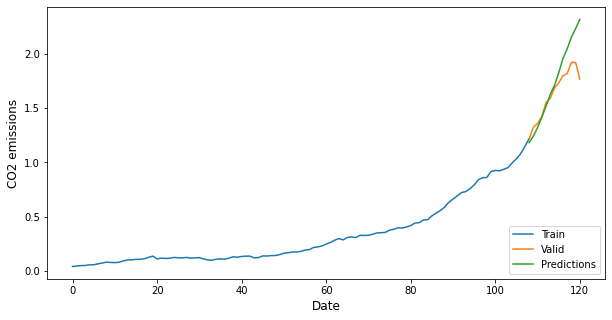

In [32]:
# Plot the train, predicted and validated data set

train = df_India[:train_size+1]
valid = df_India[train_size:]
valid['Predictions'] = predicted_CO2
plt.figure(figsize=(10,5))
#plt.title('CO2 Emissions Prediction')
plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 emissions', fontsize=12)
plt.plot(train['co2_per_capita'])
plt.plot(valid[['co2_per_capita', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [33]:
valid


,year,co2_per_capita,Predictions
108,2008,1.218,1.182882
109,2009,1.324,1.243008
110,2010,1.359,1.321688
111,2011,1.424,1.417070
112,2012,1.551,1.517875
113,2013,1.590,1.626733
114,2014,1.687,1.709737
115,2015,1.732,1.826056
116,2016,1.799,1.958200
117,2017,1.818,2.046556


### Forecasting CO2 Emissions

Lets observe a forecast iver the entire data set with LSTM model

Since we converted the data into supervised data for a look_back of 4 years, we will  add initial 4 years to prevent data truncation

In [34]:
#process data to avoid truncation
test_data = df_India.head(4)
test_data = pd.concat([test_data, df_India])
test_data

,year,co2_per_capita
0,1900,0.041
1,1901,0.045
2,1902,0.049
3,1903,0.050
0,1900,0.041
...,...,...
116,2016,1.799
117,2017,1.818
118,2018,1.922
119,2019,1.922


In [35]:
#Normalize data 
target_test = test_data.iloc[:, 1:2].values
test_scaled = scaler.fit_transform(target_test)
test_scaled.shape

(125, 1)

In [36]:
test = test_scaled[:,:]

Convert the test data into supervised data for forecasting using built LSTM model

In [37]:
#convert data
xf_test = []
yf_test = target[: , :]

for i in range(look_back, len(test)):
    xf_test.append(test[i-look_back:i, 0])

#convert to a numpy array
xf_test = np.array(xf_test)

In [38]:
#reshape the data into dimensions of LSTM model
xf_test = xf_test.reshape(xf_test.shape[0], xf_test.shape[1], 1)
xf_test.shape

(121, 4, 1)

In [39]:
yf_test.shape

(121, 1)

In [40]:
#predictions of entire dataset using LSTM Model
predicted_CO2f = modelx.predict(xf_test)
predicted_CO2f = scaler.inverse_transform(predicted_CO2f)
predicted_CO2f

array([[0.08289333],
       [0.08293516],
       [0.08297757],
       [0.0829794 ],
       [0.08289333],
       [0.08294388],
       [0.08300648],
       [0.0830487 ],
       [0.0831888 ],
       [0.08329661],
       [0.08383869],
       [0.0845979 ],
       [0.08543766],
       [0.08520886],
       [0.08587343],
       [0.08918621],
       [0.09623887],
       [0.1014775 ],
       [0.10370807],
       [0.10763669],
       [0.11261711],
       [0.11982027],
       [0.12627114],
       [0.12464193],
       [0.11332397],
       [0.11723818],
       [0.11735139],
       [0.12012462],
       [0.12284844],
       [0.12128102],
       [0.12123258],
       [0.12191369],
       [0.11924109],
       [0.11856145],
       [0.11343423],
       [0.10438205],
       [0.1007783 ],
       [0.10281575],
       [0.10887513],
       [0.11182578],
       [0.11536656],
       [0.1242345 ],
       [0.13060135],
       [0.13134088],
       [0.1350864 ],
       [0.13410056],
       [0.13017581],
       [0.125

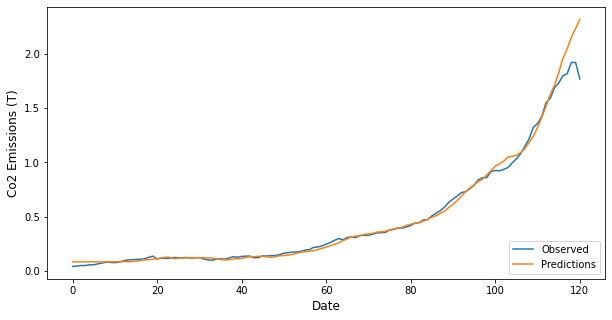

In [41]:
# Plot the original and predicted CO2 emissions set

pd.options.mode.chained_assignment = None 
train = df_India[:]
valid = df_India[:]
valid['Predictions'] = predicted_CO2f
plt.figure(figsize=(10,5))
#plt.title('Forecasting Per Capita CO2 Emissions')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Co2 Emissions (T)', fontsize=12)
plt.plot(train['co2_per_capita'])
plt.plot(valid[['Predictions']])
plt.legend(['Observed', 'Predictions'], loc='lower right')
plt.show()

#### Accuracy

In [42]:
# Evaluate mse
rmse = sqrt(mean_squared_error(yf_test,predicted_CO2f))
print("Root Mean Absoulute Error is:", round(rmse,3))

Root Mean Absoulute Error is: 0.071


In [43]:
# Determine the Mean Absoulute Error
mae = mean_absolute_error(yf_test,predicted_CO2f)
print("The Mean Absoulte Error is:", round(mae,3))

The Mean Absoulte Error is: 0.031


In [44]:
#Creare a function to calculate MAPE for our models
def MAPE(pred): 
    return np.mean(np.abs((yf_test - pred) / yf_test)) * 100

print('Mean Absolute Percentage Error is:', round(MAPE(predicted_CO2f),3))

Mean Absolute Percentage Error is: 10.036


In [45]:
valid.tail(4)

,year,co2_per_capita,Predictions
117,2017,1.818,2.046556
118,2018,1.922,2.155085
119,2019,1.922,2.233964
120,2020,1.769,2.319215


### Forecasting Future CO2 Emissions

Now lets observe future emissions using the LSTM model

In [46]:
targetx = target

#nomalize data
targetx = scaler.fit_transform(targetx)

#reshape the dataset to be used for input in loop
targetx = targetx.reshape((-1))
targetx.shape

(121,)

In [47]:
#create a Loop for LSTM input

#here, the new data generated will be used as input fir next year forecast

#look_back is the input year for forecasting

look_back = 4
def predict(n, model):
    pred_list = targetx[-look_back:]
    
    for i in range(n):
        x = pred_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        pred_list = np.append(pred_list, out)
    pred_list = pred_list[look_back-1:]
    
    return pred_list

# for n years of future co2 emissions forecasting

n = 10
forecast10 = predict(n, modelx)

In [48]:
forecast10

array([0.91866029, 1.23698652, 1.28959286, 1.34174871, 1.4608165 ,
       1.78555882, 1.94469059, 2.20505357, 2.65256357, 3.35508871,
       4.2084918 ])

In [49]:
#reshape the forecast for inverse scaling to original values
forecast10 = forecast10.reshape(forecast10.shape[0], 1)
forecast10.shape

(11, 1)

In [50]:
#inverse scaling to obtain original values
forecast10 = scaler.inverse_transform(forecast10)

**Future CO2 Emissions**

In [51]:
#forecast co2 emissions for next n years

forecast10

array([[1.769     ],
       [2.36777164],
       [2.46672417],
       [2.56482933],
       [2.78879584],
       [3.39963614],
       [3.69896299],
       [4.18870576],
       [5.03047208],
       [6.35192186],
       [7.95717308]])

In [52]:
#Add to the previous predicted dataset
forecast10 = np.append(predicted_CO2f, forecast10)
forecasts = pd.DataFrame(forecast10, columns = ['forecasts'])
forecasts

,forecasts
0,0.082893
1,0.082935
2,0.082978
3,0.082979
4,0.082893
...,...
127,3.698963
128,4.188706
129,5.030472
130,6.351922


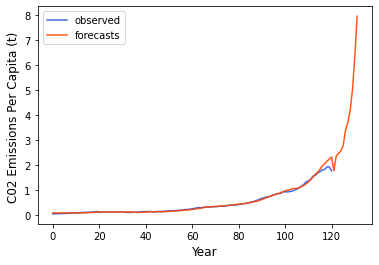

In [53]:
# Plot the original and LSTM forecasting CO2 emissions
train = df_India[:]
ax = train['co2_per_capita'].plot(label='observed', color='royalblue', legend=True)

#plot forecasted values
forecasts.plot(ax=ax, label='forecasts', color='orangered', alpha=0.9, legend=True)

ax.set_xlabel('Year', size=12)
ax.set_ylabel('C02 Emissions Per Capita (t) ', size=12)
#ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2030) \n', size=14)

plt.legend()
plt.show()

***Results Observed***

From above results of LSTM Model,

>- LSTM Model has marginably Higher MAPE than the ARIMA, Holt-winter's Models for this data

>- LSTM Model proedictions provides us better insights on emissions on absence of COVID-19 Pandemic. The pandemic resulted in huge dip in the emissions in year 2020.
    
>- LSTM Predictions show that at this curent rate, India's emissions intensity is increasing at exponential rate. This is similar to real life situation.

>- Reducing emissions intensity by 45% by 2030 might not be achievable by intensive reductions in intensity

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

***Tasks***

>- Data Preprocessing
    - _Fixing Random Seeds_
    - _Normalizing data_
    - _Train-Test Split_
    - _creating sequences_

>- Built LSTM Model (change graph labels)
    - _reiterate till max forecast results_
        - _hyperparameter tuning_
    - _evaluate Performance_
    - _Forecast Emissions for target years_